# Predicting Protein–Ligand Binding in 7M41 with AlphaFold 3

## Table of Contents

1. Introduction
2. Environment Setup and Installation
3. Data Preparation
    - 3.1 Download the Protein Sequence
    - 3.2 Preparing the `input.json` File
4. Running AlphaFold 3 via Docker
5. Key Tools for Analysis
6. pLDDT Scores
    - 6.1 Converting mmCIF to PDB
    - 6.2 Visualizing pLDDT Scores
    - 6.3 Identify Residues with Low pLDDT Atoms
    - 6.4 Why These Residues May Be Low Confidence
7. PAE Scores
    - 7.1 Visualizing PAE
    - 7.2 Identifying High PAE Pairs
8. Preparing Structures: Download, Convert, and Clean
    - 8.1 Downloading the Experimental Structure
    - 8.2 Cleaning Example
9. Comparing Predicted and Experimental Structures
    - 9.1 Aligning the Structures
    - 9.2 Visualizing the Structures
10. Conclusion


## 1. Introduction

In our [1ATP tutorial](./af3_1ATP_server_tutorial.ipynb), we leveraged the AlphaFold 3 public server to predict intricate 3D structures of protein-ligand complexes. This powerful tool offers remarkable insights but also has limitations. For example, the AlphaFold 3 public server restricts ligands to a predefined set of CCD codes, which can constrain analyses involving custom ligands such as 7M41. Notably, 7M41 features a non-standard small-molecule ligand (YQG) that is not included in the server’s CCD list. To fully leverage AlphaFold 3’s capabilities, including modeling custom ligands, it is necessary to run the model locally. Running AlphaFold 3 locally provides full control over input files and prediction configurations, supporting customized predictions such as analyzing non-standard ligands, using specific templates, and incorporating MSA features. A local setup also allows integration with downstream analysis tasks, enabling comparisons between predicted and experimental structures and evaluations of model confidence using metrics like pLDDT and RMSD.

In this tutorial, we run AlphaFold 3 locally. We will briefly discuss how to set up the system, prepare the protein data, configure the input files, and run the model prediction in Docker. Additionally, instead of relying on ChimeraX, we dive into more granular data manipulation and visualization using Biopython, MDAnalysis, and py3Dmol to better understand the predicted results. We will also explore key model outputs, including the Predicted Aligned Error (PAE), Predicted Local Distance Difference Test (pLDDT) scores, and compute Root Mean Square Deviation (RMSD), to assess prediction accuracy and uncertainty. Finally, we will generate 3D alignment views to compare predicted structures with experimental data or other models.

For a high-level walk-through of the AlphaFold 3 model, please refer to the dedicated [walk-through tutorial](./af3_walkthrough.ipynb).

## 2. Environment Setup and Installation

AlphaFold 3 requires a Linux environment with Docker and a compatible NVIDIA GPU to run locally. This section covers everything you need to install and configure AlphaFold 3 on your system.

### 2.1. Install Docker and NVIDIA Support (Local Runs Only)
Below are the official steps to install and configure AlphaFold 3 on your system. We recommend following the  [official installation guide](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#enabling-rootless-docker) for complete instructions and troubleshooting tips.

1. [Install docker](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#installing-nvidia-support-for-docker)
2. [Enable rootless docker](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#enabling-rootless-docker)
3. [Install NVIDIA GPU driver](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#obtaining-genetic-databases)
4. [Set up NVIDIA Docker support](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#installing-nvidia-support-for-docker)
5. [Download and configure the AlphaFold 3 database](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#obtaining-genetic-databases)
6. Clone the source code:
```bash
   git clone https://github.com/google-deepmind/alphafold3.git
```

7. [Request access to the AlphaFold 3 model parameters](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#obtaining-model-parameters)
8. [Build the docker container:](https://github.com/google-deepmind/alphafold3/blob/main/docs/installation.md#obtaining-model-parameters)

```bash
    docker build -t alphafold3 -f docker/Dockerfile .
```

### 2.2 Install Packages

In [79]:
# Install packages
!pip install gemmi biopython mdanalysis numpy py3Dmol

### 2.3 Download Tutorial Files

In [80]:
!rm -rf AlphaFold-3-Tutorial-Series
!git clone https://github.com/richcmwang/AlphaFold-3-Tutorial-Series.git

Cloning into 'AlphaFold-3-Tutorial-Series'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 373 (delta 90), reused 0 (delta 0), pack-reused 235 (from 1)
Receiving objects: 100% (373/373), 12.76 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (200/200), done.


## 3. Data Preparation

### 3.1 Download the Protein Sequence

AlphaFold 3 requires the protein sequence in FASTA format. To obtain this for 7M41 Chain A, navigate to the RCSB PDB entry for [7M41](https://www.rcsb.org/structure/7M41), and download the FASTA file with content like:

```
>7M41_1|Chains A, B|Hepatitis A virus cellular receptor 2|Homo sapiens (9606)
SEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKLVIK
```

Copy only the sequence lines (excluding the header) into the `sequence` section of the `input.json` file, following the input setup instructions provided in the next section

### 3.2 Preparing the `input.json` File
The input.json file defines everything AlphaFold 3 needs to predict a structure, including protein sequences, ligands, and configuration options. To make the setup clearer, comments are included next to each input section to explain their purpose. An example input.json for 7M41 looks like this:

```json
{
  "name": "7M41",                      // Job name

  "modelSeeds": [42, 43],              // Seeds for sampling

  "sequences": [
    {
      "protein": {
        "id": ["A"],                   // Chain ID for the protein
        "sequence": "SEVEYRAEVGQN...", // Protein sequence (FASTA)
        "unpairedMsa": "",             // Leave empty if no custom MSA
        "pairedMsa": ""                // Leave empty if no paired MSA
      }
    },
    {
      "ligand": {
        "id": "C",                     // Chain ID for the ligand
        "ccdCodes": ["YQG"]            // CCD code for the YQG molecule
      }
    },
    {
      "ligand": {
        "id": "D",                     // Chain ID for a second ligand
        "ccdCodes": ["CA"]             // CCD code for calcium ion
      }
    }
  ],

  "dialect": "alphafold3",             // AlphaFold 3 input format
  "version": 3                         // AlphaFold version
}
```      

Once the input.json file is set up, you’ll be ready to run AlphaFold 3 locally to generate the structure prediction.

## 4. Running AlphaFold 3 via Docker

After setting up Docker and downloading the necessary files, you can launch AlphaFold 3 using the following command. This example assumes you’ve organized your input, output, model, and database directories described in the previous section, and that you’re running on a machine with a compatible GPU:

```bash
docker run -it \                                # Start/run a container
  --gpus all \                                  # Use all GPUs
  --volume "$INPUT_DIR:/root/af_input" \        # Mount local input
  --volume "$OUTPUT_DIR:/root/af_output" \      # Mount local output
  --volume "$MODEL_DIR:/root/models" \          # Mount local model
  --volume "$DB_DIR:/root/public_databases" \   # Mount local database
  alphafold3 \                                  # Docker image name
  python run_alphafold.py \                              
    --json_path "/root/af_input/$INPUT_FILE" \  # Input path in container
    --model_dir /root/models \                  # Model path in container
    --output_dir /root/af_output \              # Output path in container
    --run_data_pipeline=True \                  # Enable MSA/template search
    --flash_attention_implementation=xla        # Use XLA backend (opt)
```

Some GPUs may trigger runtime errors due to attention kernel or XLA compatibility issues. These can often be resolved by using the appropriate flags. For Docker, adding `-e XLA_FLAGS="--xla_disable_hlo_passes=custom-kernel-fusion-rewriter"` disables a problematic compiler pass. For Python, adding `--flash_attention_implementation=xla` selects a more compatible attention backend. If you encounter errors, check the error message to determine which flag is needed.

Once AlphaFold 3 predictions are complete, we can plot the confidence scores such as pLDDT and PAE to understand the model’s certainty in the predictions and then prepare them for further analysis in the steps in the next sections.

## 5. Key Tools for analysis

In this tutorial, we introduce three essential Python libraries to analyze and prepare protein–ligand structures.

GEMMI is a fast and modern library for parsing macromolecular structure files. We use GEMMI to read the predicted CIF output from AlphaFold 3 and convert it to PDB format, enabling downstream tools like MDAnalysis to access per-atom attributes such as B-factors (which store pLDDT scores).

Biopython is a versatile library for manipulating biological structure files. We use its PDB modules to align predicted structures to experimental references by applying appropriate rotations and translations, and to save cleaned or aligned PDB files.

MDAnalysis is a powerful framework for selecting, modifying, and analyzing molecular structures. We use it to retrieve and plot pLDDT confidence scores, isolate relevant protein chains and ligands, remove irrelevant parts, and prepare both predicted and experimental structures for downstream tasks like RMSD calculation and molecular docking.

Run the following cell to suppress irrelevant warnings

In [81]:
import warnings
from Bio import BiopythonDeprecationWarning
warnings.simplefilter('ignore', BiopythonDeprecationWarning)
warnings.filterwarnings(
    "ignore",
    message="Found no information for attr: 'formalcharges'.*", # Use regex to match the message
    category=UserWarning,
    module="MDAnalysis.coordinates.PDB" # Target the specific module
)
warnings.filterwarnings(
    "ignore",
    message="Unit cell dimensions not found. CRYST1 record set to unitary values.*",
    category=UserWarning,
    module="MDAnalysis.coordinates.PDB"
)

Run the following cell to import the required Python packages.

In [82]:
# Core Python
import os                                # For file and path operations
import numpy as np                       # For numerical calculation
import matplotlib.pyplot as plt          # For plotting data (e.g. , pLDDT, RMSD)
import json                              # For reading JSON file
import pandas as pd                      # For creating dataframe

# Gemmi
import gemmi                             # For converting CIF files to PDB files

# Bioinformatics tools
from Bio.PDB import (
    PDBIO,                               # Writes PDB files
    PDBList,                             # Fetches PDB files from the RCSB
    PDBParser,                           # Parses PDB files
    Superimposer                         # For aligning structures
)

# MDAnalysis
import MDAnalysis as mda                 # For selecting and analyzing atoms, residues, chains
from MDAnalysis.analysis import align    # For RMSD calculation and structure alignment

# Visualization
import py3Dmol                    # For interactive 3D visualization

Set Working Directory

In [83]:
os.chdir('AlphaFold-3-Tutorial-Series/tutorials')

## 6. pLDDT Scores

To assess the confidence level of the AlphaFold 3 prediction, we examine the pLDDT scores.

In AlphaFold 3, pLDDT is a per-atom confidence score that estimates how confidently the model predicts the local structure around each atom. It’s based on the local distance difference test (LDDT), which compares the predicted local distances from each atom to the anchor atoms (Cα for proteins) of neighboring residues. Internally, the model predicts a distribution over possible distance errors and computes the expected value as the final pLDDT score. This single value reflects how closely the predicted local structure is expected to align with experimental structures. (For further details, see Section 4.3.1 in the [Supplementary Information for AlphaFold 3](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-024-07487-w/MediaObjects/41586_2024_7487_MOESM1_ESM.pdf).)

These scores are typically stored in the B-factor field of the output mmCIF file. In experimental structures, the B-factor reflects the degree of atomic displacement: lower values indicate more ordered, rigid regions, while higher values correspond to more flexible, disordered areas. In AlphaFold 3 outputs, however, the B-factor field is repurposed to store pLDDT scores.  We will use MDAnalysis to extract and plot the pLDDT values from the prediction.



### 6.1 Converting mmCIF to PDB

Since MDAnalysis requires PDB files for parsing per-atom attributes like B-factors (which hold the pLDDT scores), we first read the predicted model CIF file using GEMMI (a modern, high-performance library for macromolecular structures) and convert it to PDB format. This allows us to retrieve and plot the pLDDT values from the predicted model output.

In [84]:
import gemmi

# Input and output paths
predicted_file = "../data/local_output/tim3_autotemplate_rec10_model.cif"
predicted_pdb_file = "../data/processed/tim3_autotemplate_rec10_model.pdb"

# Read the mmCIF file
structure = gemmi.read_structure(predicted_file)

# Optionally assign a model number (if there are multiple models)
structure.renumber_models()

# Write to PDB
structure.write_pdb(predicted_pdb_file)

### 6.2 Visualizing pLDDT Scores

We use the atom serial numbers from the PDB file as the x-axis when plotting pLDDT. This allows us to directly trace back to the original atoms or residues in the structure file, making it easier to investigate regions where pLDDT values are low.

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


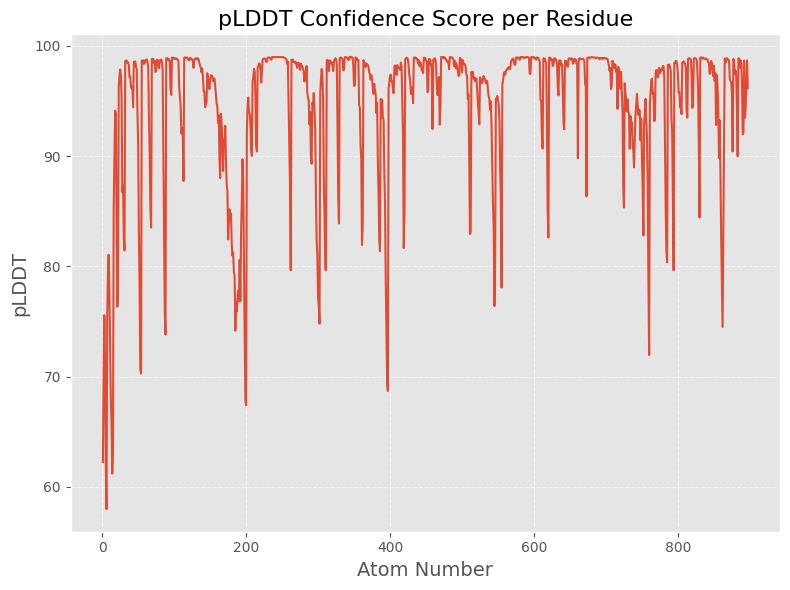

In [85]:
predicted_model_file = "../data/processed/tim3_autotemplate_rec10_model.pdb"
u = mda.Universe(predicted_model_file)
plddt = u.atoms.tempfactors  # pLDDT stored in B-factor
atom_ids = u.atoms.ids

plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(atom_ids, plddt, linewidth=1.5)
plt.xlabel("Atom Number", fontsize=14)
plt.ylabel("pLDDT", fontsize=14)
plt.title("pLDDT Confidence Score per Residue", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Most of the atoms have high pLDDT values. We now identify the atoms and their corresponding residues with pLDDT scores below 70.

### 6.3 Identify residues with low pLDDT atoms

Identify atoms with low pLDDT by filtering pLDDT(u.atoms.bfactor), which returns a NumPy array of values. Note that the resulting indices (e.g., from np.where) correspond to array positions in u.atoms, not to atom IDs from the original structure file.

In [86]:
# find indices for atoms with low pLDDT
low_confidence_indices = np.where(plddt < 70)[0]  # get indices of low-confidence residues
print("Low-confidence atoms:", low_confidence_indices)

Low-confidence atoms: [  0   4   5  11  12  13  14 198 199 395 396]


In [87]:
# show residues for these atoms
for idx in low_confidence_indices:
    atom = u.atoms[idx]
    print(f"Atom Index: {idx} | Atom ID: {atom.id} | Atom Name: {atom.name} | Residue: {atom.resname} {atom.resid} | Chain: {atom.segid}")

Atom Index: 0 | Atom ID: 1 | Atom Name: N | Residue: SER 1 | Chain: A
Atom Index: 4 | Atom ID: 5 | Atom Name: CB | Residue: SER 1 | Chain: A
Atom Index: 5 | Atom ID: 6 | Atom Name: OG | Residue: SER 1 | Chain: A
Atom Index: 11 | Atom ID: 12 | Atom Name: CG | Residue: GLU 2 | Chain: A
Atom Index: 12 | Atom ID: 13 | Atom Name: CD | Residue: GLU 2 | Chain: A
Atom Index: 13 | Atom ID: 14 | Atom Name: OE1 | Residue: GLU 2 | Chain: A
Atom Index: 14 | Atom ID: 15 | Atom Name: OE2 | Residue: GLU 2 | Chain: A
Atom Index: 198 | Atom ID: 199 | Atom Name: OD1 | Residue: ASN 26 | Chain: A
Atom Index: 199 | Atom ID: 200 | Atom Name: ND2 | Residue: ASN 26 | Chain: A
Atom Index: 395 | Atom ID: 396 | Atom Name: NH1 | Residue: ARG 52 | Chain: A
Atom Index: 396 | Atom ID: 397 | Atom Name: NH2 | Residue: ARG 52 | Chain: A


### 6.4 Why might these residues be flagged as low-confidence?

Residues like GLU, ASN, and ARG have long, often charged or polar side chains that tend to be more disordered in protein structures. These side chains usually stick out into the solvent and can move around, which makes them harder to predict accurately. GLU and ARG are often found on the protein surface, where they interact with water, ions, or other molecules, increasing their flexibility and lowering the confidence in their exact positions. SER 1 is the first residue in the protein sequence (as confirmed from the FASTA sequence of 7M41), and low confidence here is typical because the N-terminal end of a protein is usually highly flexible and disordered.

## 7. PAE Scores

PAE (Predicted Aligned Error) is a pairwise confidence measure used by AlphaFold 3 to estimate the expected error in the relative position of two residues.

Specifically, for every pair of residues $(i, j)$ in the protein, the PAE score tells you how much the distance between the predicted and ground truth structures at residue $j$ might deviate (in Ångströms) if you were to align the predicted local rigid frame of residue $i$ to its ground truth frame using translation and rotation.

Lower PAE values (e.g., close to 0 Å) indicate high confidence that the model has correctly predicted the distance between the two residues, while higher values (e.g., above 10 Å) indicate more uncertainty. This makes the PAE matrix a valuable tool for understanding which parts of the structure prediction are more reliable, and for identifying flexible or uncertain regions.

### 7.1 Visualizing PAE

AlphaFold 3 uses different tokenization strategies for proteins and ligands. Protein residues are treated as single tokens, reflecting their repeating backbone structure. For ligands, however, AlphaFold 3 tokenizes each individual atom to capture their unique chemical features and interactions.

This tokenization impacts the Predicted Aligned Error (PAE) calculations:

- Protein–Protein: PAE measures alignment errors between pairs of protein residues.

- Protein–Ligand: PAE includes errors between protein residues and ligand atoms.

- Ligand–Ligand: PAE captures errors between pairs of ligand atoms within the same molecule.

This approach provides a more granular confidence assessment for protein-ligand complexes than simply classifying an entire ligand as a single residue, as is typical in PDB files.

#### 7.1.1 Sanity Check

We'll run a quick sanity check to confirm that our interpretation of the PAE calculation aligns with the data.

In [88]:
# Load the PAE JSON
with open("../data/local_output/tim3_autotemplate_rec10_confidences.json") as f:
    confidence_data = json.load(f)

pae = np.array(confidence_data["pae"])  # AlphaFold 3 stores PAE as a 2D list

print(f"The PAE matrix shape is {pae.shape[0]} x {pae.shape[1]} (number of tokens X number of tokens).")

The PAE matrix shape is 142 x 142 (number of tokens X number of tokens).


We now verify whether the total number of tokens (from both the protein and the ligands) matches the dimensions of the PAE matrix.










In [89]:
# Number of residues in chain A
residues_in_chainA = u.select_atoms("segid A").residues
num_residues_chainA = len(residues_in_chainA)
print(f"Number of residues in Chain A: {num_residues_chainA}")

# Number of atoms in YQG
atoms_in_YQG = u.select_atoms("resname YQG")
num_atoms_YQG = len(atoms_in_YQG)
print(f"Number of atoms in YQG: {num_atoms_YQG}")

# Number of atoms in CA (calcium)
atoms_in_CA = u.select_atoms("resname CA")
num_atoms_CA = len(atoms_in_CA)
print(f"Number of atoms in CA: {num_atoms_CA}")

# Total Number of tokens for PAE calculation
total_num_tokens = num_residues_chainA+num_atoms_YQG+num_atoms_CA
print(f"Total number of tokens for PAE calculation should be {total_num_tokens}")

Number of residues in Chain A: 109
Number of atoms in YQG: 32
Number of atoms in CA: 1
Total number of tokens for PAE calculation should be 142


We have confirmed that total number of tokens from both protein and ligands matches the dimensions of the PAE matrix.

#### 7.1.2 Generating the PAE Heatmap

Run the following cell to plot PAE heatmap:

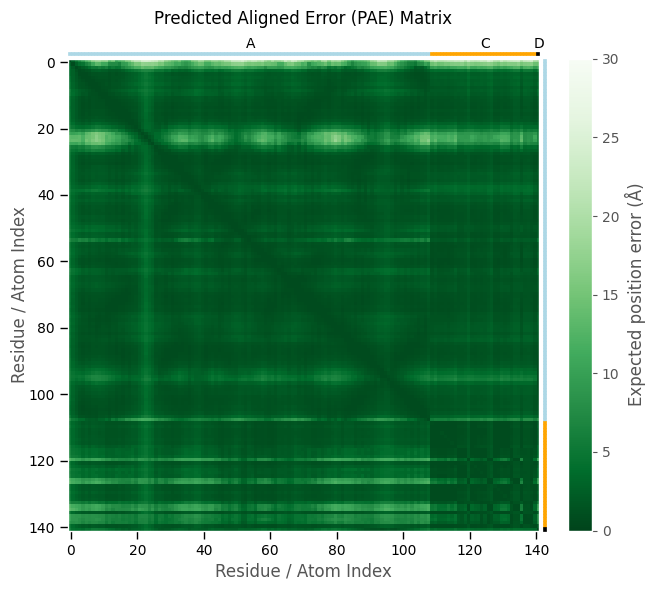

In [90]:
# === 1. Define Chain color and label ===
chain_color_map = {"A": "lightblue", "C": "orange", "D": "black"}
chain_labels = {"A": "A", "C": "C", "D": "D"}

# === 2. Map chain IDs to colors ===
chain_colors = [chain_color_map[c] for c in confidence_data['token_chain_ids']]

# === 3. Create the figure and axes ===
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(pae, cmap="Greens_r", vmin=0, vmax=30)

# === 4. Colorbar for heat map ===
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Expected position error (Å)", fontsize=12)

# === 5. Add thicker colored bars (top and right side) ===
bar_thickness = 1.0
for i, color in enumerate(chain_colors):
    # Top bar
    _ = ax.add_patch(
        plt.Rectangle(
            (i - 0.5, -2.5),  # Position (x, y)
            1,                # Width
            bar_thickness,    # Height
            color=color,
            transform=ax.transData,
            clip_on=False
        )
    )
    #  Side bar
    _= ax.add_patch(
        plt.Rectangle(
            (142.5, i - 0.5),  # Adjust x-position to be outside heatmap
            bar_thickness,     # Width
            1,                 # Height
            color=color,
            transform=ax.transData,
            clip_on=False
        )
    )

# === 6. Add chain labels above the colored top bar ===
start_idx = 0
for chain_id in ["A", "C", "D"]:
    count = confidence_data['token_chain_ids'].count(chain_id)
    mid_idx = start_idx + count / 2
    _ = ax.text(
        mid_idx,
        -5.0,                  # position (x, y) move farther above the bar
        chain_labels[chain_id],
        ha="center",
        va="center",
        fontsize=10,
    )
    start_idx += count

# === 7. Tick foramtting =====
tick_positions = np.arange(0, 143, 20)  # 0 to 142 (inclusive)
tick_labels = [str(x) for x in tick_positions]

# Apply to both axes (add 0.5 to center ticks on heatmap coordinates)
_  = ax.set_xticks([x + 0.5 for x in tick_positions])  # +0.5 centers ticks
_  = ax.set_yticks([y + 0.5 for y in tick_positions])
_  = ax.set_xticklabels(tick_labels, rotation=0)
_  = ax.set_yticklabels(tick_labels)

# customize tikces
ax.tick_params(axis='both', which='major',
               length=6, width=1, direction='out',
               colors='black', labelsize=10)

# turn off grid
ax.grid(False)

# === 8. Labels and Title ===
_ = ax.set_xlabel("Residue / Atom Index", fontsize=12, labelpad=3)
_ = ax.set_ylabel("Residue / Atom Index", fontsize=12, labelpad=0)
_ = ax.set_title("Predicted Aligned Error (PAE) Matrix", fontsize=12, pad=25)

#  === 9. Final layout and Display ===
plt.tight_layout()
plt.show()

Note that most PAE values are small, indicating high confidence in the relative positioning of residues. Next, we will identify pairs with high PAE values, as these may correspond to regions of local uncertainty worth investigating further.

### 7.2 Identifying high PAE pairs

In [91]:
# threshold for high PAE
threshold = 20
high_pae_indices = np.argwhere(pae > threshold)

AlphaFold 3’s confidence JSON file includes token_res_ids, which are residue numbers specific to each chain. In multi-chain complexes, these numbers can repeat across different chains. To uniquely identify a residue within a particular chain (e.g., when using MDAnalysis), it’s necessary to use both token_res_ids and token_chain_ids from the confidence JSON file.

In [92]:
mda_info = {index: (chain_id, res_id) for index, (chain_id, res_id) in enumerate(
    zip(confidence_data['token_chain_ids'], confidence_data['token_res_ids']))}

Store pairs with large PAE in a dataframe

In [93]:
# === 1. Collect Data for DataFrame ====
pae_data_for_df = []
k = 20

for i, j in high_pae_indices:
    # define the corresponding residues of i and j
    res_i_obj = u.select_atoms(f"resnum {mda_info[i][1]} and segid {mda_info[i][0]}").residues[0]
    res_j_obj = u.select_atoms(f"resnum {mda_info[j][1]} and segid {mda_info[j][0]}").residues[0]

    # Create a dictionary for the current row with the new column names
    row_data = {
        'Residue_1_Chain': res_i_obj.segid, # Added Chain for unique identification
        'Residue_1_Name': res_i_obj.resname,
        'Residue_1_Num': res_i_obj.resnum,
        'Residue_2_Chain': res_j_obj.segid, # Added Chain for unique identification
        'Residue_2_Name': res_j_obj.resname,
        'Residue_2_Num': res_j_obj.resnum,
        'PAE_Value': pae[i, j] # Stored as a float for numerical operations
    }
    pae_data_for_df.append(row_data)

# === 2. Create DataFrame ===
pae_df = pd.DataFrame(pae_data_for_df)

# === 3. Sort by PAE_Value ===
pae_df_sorted = pae_df.sort_values(by='PAE_Value', ascending=False)


# === 4.Show top k  ===
# to_string() prevents truncation and show two decimal places for PA
print(f"\nTop {k} PAE Pairs\n")
print(pae_df_sorted.head(k).to_string(index=False, float_format="%.2f"))



Top 20 PAE Pairs

Residue_1_Chain Residue_1_Name  Residue_1_Num Residue_2_Chain Residue_2_Name  Residue_2_Num  PAE_Value
              A            SER              1               A            PRO             24      24.10
              A            SER              1               C            YQG              1      24.10
              A            SER              1               A            ALA             23      23.70
              A            SER              1               A            GLY             25      23.60
              A            SER              1               A            ASP             53      23.40
              A            SER              1               C            YQG              1      23.10
              A            SER              1               C            YQG              1      23.00
              A            SER              1               C            YQG              1      23.00
              A            SER              1         

The high PAE values identified may be valuable for guiding further investigations such as focusing on these regions during experimental validation or docking analyses. For now, let’s proceed to visualizing the predicted structure and overlaying this confidence data in 3D, which can provide a more intuitive sense of where the model predicts uncertainty in the structure.

## 8. Preparing Structures: Download, Convert, and Clean

After generating the AlphaFold 3 predictions, the next step is to download the corresponding experimental structures from the PDB, convert the predicted structures from .cif to .pdb format, and clean both the experimental and predicted structures by removing irrelevant chains and heteroatoms. This ensures that the structures are ready for consistent downstream analysis.

Why is cleaning necessary?

Protein structures are often stored in CIF formats. However, these files can include multiple chains, non-protein entities, or other structural elements that complicate downstream analysis. For example, the experimental structure of 7M41 includes additional protein chains (such as Chain B) that are not part of the target protein-ligand complex being studied. Cleaning and preparing the structure ensures that the analysis focuses on the specific protein chain(s) and ligands relevant to the study (such as Chain A and the YQG ligand) while removing irrelevant chains. This also makes it easier to align the cleaned structure with other models or predictions, improving the accuracy of subsequent workflows—such as RMSD calculations, pocket analysis, or docking—and ensuring results are consistent and reproducible.

### 8.1 Downloading the Experiment Structure

First, download the experimental structure (7M41) from the RCSB PDB and save it in `../data/processed` in PDB format, using default name `pdb7M41.ent`.

In [94]:
pdb_id = "7M41"
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdb_id, file_format="pdb", pdir="../data/processed")

Structure exists: '../data/processed/pdb7m41.ent' 


'../data/processed/pdb7m41.ent'

### 8.2 Cleaning Example

Once the 7M41 experimental structure is downloaded and the AlphaFold 3 prediction is complete, clean both structures (predicted and experimental) by selecting only Chain A, the CA ion, and the YQG ligand. For example:

In [95]:
def clean_structure(input_file, output_file, chain_id="A", lig_resname="YQG"):
    """
    Clean the given structure by selecting Chain A (default), CA ions, and the specified ligand.
    Saves the cleaned structure to the output file.

    Parameters:
    - input_file (str): Path to the input PDB file.
    - output_file (str): Path to the cleaned PDB file.
    - chain_id (str or tuple of str): The chain identifier to select
        AlphaFold3 predicted: use ("A", "C", "D")
        experimental: use default "A"
    - lig_resname (str): The residue name of the ligand (default: "YQG").
    """
    universe = mda.Universe(input_file)

    if isinstance(chain_id, str):
        # Single chain ID provided as a string
        chain = universe.select_atoms(f"segid {chain_id} and protein")
        ligand = universe.select_atoms(f"segid {chain_id} and resname {lig_resname}")
        calcium = universe.select_atoms(f"segid {chain_id} and resname CA")
    elif isinstance(chain_id, tuple):
        # Tuple of chain IDs provided (protein, ligand, calcium,)
        protein_chain, ligand_chain, calcium_chain = chain_id
        chain = universe.select_atoms(f"segid {protein_chain} and protein")
        ligand = universe.select_atoms(f"segid {ligand_chain} and resname {lig_resname}")
        calcium = universe.select_atoms(f"segid {calcium_chain} and resname CA")
    else:
        raise ValueError("chain_id must be a string or a tuple of strings.")

    selection = chain + calcium + ligand

    if os.path.exists(output_file):
        os.remove(output_file)

    with mda.Writer(output_file) as writer:
        writer.write(selection)

    print(f"Saved '{output_file}' with Chain {chain_id}, CA ion, and {lig_resname} ligand.")

In [96]:
# clean 7m41 experimental structure
input_file = "../data/processed/pdb7m41.ent"
output_file = "../data/processed/7m41_exp_cleaned.pdb"
clean_structure(input_file, output_file, chain_id="A", lig_resname="YQG")

Saved '../data/processed/7m41_exp_cleaned.pdb' with Chain A, CA ion, and YQG ligand.


In [97]:
# clean 7m41 predicted structure
input_file = "../data/processed/tim3_autotemplate_rec10_model.pdb"
output_file = "../data/processed/7m41_predicted_cleaned.pdb"
clean_structure(input_file, output_file, chain_id=("A", "C", "D"), lig_resname="YQG")

Saved '../data/processed/7m41_predicted_cleaned.pdb' with Chain ('A', 'C', 'D'), CA ion, and YQG ligand.


/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


Note that in the experimental structure, both YQG and CA are labeled as chain A, whereas in the AlphaFold 3 prediction, they are labeled as chains C and D, respectively. This is because, in the input.json configuration for AlphaFold 3, ligands must be input as separate chains from the protein for proper structure prediction.

## 9. Comparing Predicted and Experimental Structures

In this section, we will align the predicted and experimental structures, calculate the overall RMSD, assess per-residue RMSD, and visualize the aligned structures in 3D. These steps help us evaluate the quality of the AlphaFold 3 prediction and understand how well it matches the experimental data.



### 9.1 Aligning the predicted and experimental structures

To compare the AlphaFold 3 predicted structure with the experimental structure, it is essential to align them in the same coordinate frame. This alignment lets us assess how closely the predicted structure matches the experimental one, both globally and at the level of individual residues. We achieve this by applying a rotation and translation to the predicted structure so that its backbone atoms (usually alpha carbons) best overlap with those of the experimental structure. In this tutorial, we use Biopython to compute and apply the necessary rotation and translation matrices.

In [98]:
predicted_file = "../data/processed/7m41_predicted_cleaned.pdb"
experimental_file = "../data/processed/7m41_exp_cleaned.pdb"

In [99]:
# === 1. Parse the structures ===
parser = PDBParser(QUIET=True)
exp_structure = parser.get_structure("exp", experimental_file)
pred_structure = parser.get_structure("pred", predicted_file)

In [100]:
# === 2. Select chain A ===
exp_chain = exp_structure[0]['A']
pred_chain = pred_structure[0]['A']

In [101]:
# === 3. Collect protein residues located at 1–109, excluding CA (ion) and YQG (ligand) ===
excluded_residues = ('CA', 'YQG')
exp_residues = [
    res for res in exp_chain
    if 1 <= res.get_id()[1] <= 109 and res.get_resname() not in excluded_residues
]
pred_residues = [
    res for res in pred_chain
    if 1 <= res.get_id()[1] <= 109 and res.get_resname() not in excluded_residues
]

In [102]:
# === 4. Confirm matching residues ===
for exp_res, pred_res in zip(exp_residues, pred_residues):
    exp_id = exp_res.get_id()[1]
    pred_id = pred_res.get_id()[1]
    if exp_id != pred_id:
        print(f"Residue mismatch: Experimental {exp_id} vs Predicted {pred_id}")
    if exp_res != pred_res:
        print(f" Residue mismatch {exp_res} vs {pred_res}")

In [103]:
# === 5. Collect CA (C_alpha) atoms for alignment ===
ref_atoms = []
mov_atoms = []
aligned_residues = []
for exp_res, pred_res in zip(exp_residues, pred_residues):
    try:
        ref_atoms.append(exp_res['CA'])
        mov_atoms.append(pred_res['CA'])
        aligned_residues.append(exp_res.get_id()[1])
    except KeyError:
        print(f"Missing CA in residue {exp_res.get_id()[1]} — skipping.")

Next, apply the computed transformation (rotation and translation) to all atoms in the predicted structure, including both CA and the ligand YQG.

In [104]:
# === 6. Align ===
# Calculates the optimal rotation and translation
# (using the Kabsch algorithm)
# to superimpose one set of points onto another
super_imposer = Superimposer()

# Find the rotation matrix and translation vector
# that best aligns mov_atoms to ref_atoms.
super_imposer.set_atoms(ref_atoms, mov_atoms)

# applies the calculated transformation (rotation + translation)
# to all atoms in the predicted structure (including CA and YQG).
super_imposer.apply(pred_structure.get_atoms())
print(f"Alignment complete. RMSD: {super_imposer.rms:.3f} Å")

Alignment complete. RMSD: 1.702 Å


In [105]:
# === 7. Save the aligned predicted structure ===
io = PDBIO()
io.set_structure(pred_structure)
io.save("../data/processed/7m41_predicted_aligned.pdb")
print("Aligned structure saved to '../data/processed/7m41_predicted_aligned.pdb'.")

Aligned structure saved to '../data/processed/7m41_predicted_aligned.pdb'.


In [106]:
# === 8. Calculate per-residue RMSD ===
ref_coords = np.array([atom.get_coord() for atom in ref_atoms])
mov_coords = np.array([atom.get_coord() for atom in mov_atoms])
per_residue_rmsd = np.sqrt(np.sum((ref_coords - mov_coords)**2, axis=1))

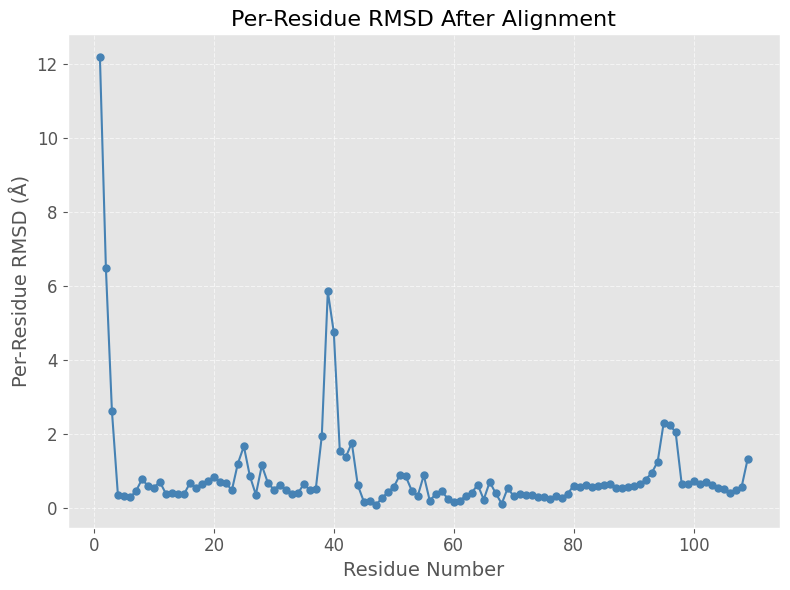

In [107]:
# === 9. Visualize per-residue RMSD ===
_ = plt.style.use('ggplot')
_ = plt.figure(figsize=(8, 6));
_ = plt.plot(
    aligned_residues, per_residue_rmsd, marker='o', markersize=5,
    linewidth=1.5, color='steelblue');

_ = plt.xlabel('Residue Number', fontsize=14);
_ = plt.ylabel('Per-Residue RMSD (Å)', fontsize=14);
_ = plt.title('Per-Residue RMSD After Alignment', fontsize=16)
_ = plt.grid(True, linestyle='--', alpha=0.6);

_ = plt.xticks(fontsize=12);
_ = plt.yticks(fontsize=12);

_ = plt.tight_layout();
_ = plt.savefig("per_residue_rmsd_plot.png", dpi=300);
_ = plt.show();  # Semicolon suppresses extra outputs

### 9.2 Visualizing of the predicted and experimental structures

As discussed in Section 5.3, AlphaFold 3 stores pLDDT confidence scores in the B-factor field of the output structure. When visualizing the predicted structure locally, we color it based on these scores using a blue-to-red gradient: regions of high confidence (high pLDDT) appear in blue, while low-confidence regions shift through green, yellow, and orange to red. For contrast, the experimental structure is shown in grey.

In [108]:
import py3Dmol
import os

# 1. Define your two local PDB file paths
pdb_file1 = "../data/processed/7m41_predicted_aligned.pdb"   # predicted model: 0
pdb_file2 = "../data/processed/7m41_exp_cleaned.pdb"         # experimental model: 1

# 2️. Convert to absolute paths (optional, for clarity)
pdb_file1 = os.path.abspath(pdb_file1)
pdb_file2 = os.path.abspath(pdb_file2)

# 3. Read the PDB files into strings
with open(pdb_file1, "r") as f1:
    pdb_data1 = f1.read()

with open(pdb_file2, "r") as f2:
    pdb_data2 = f2.read()

# 4. Create a py3Dmol viewer
view = py3Dmol.view(width=800, height=600)

# 5. Load both PDB data as separate models
_ = view.addModel(pdb_data1, "pdb")  # model index 0
_ = view.addModel(pdb_data2, "pdb")  # model index 1

# 6. Apply cartoon representation to both models
_ = view.setStyle(
    {'model': 0}, {'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 100}}}
)
_ = view.setStyle(
    {'model': 1}, {'cartoon': {'color': 'lightgrey'}}
)


# Add stick representation for ligand 'YQG' in both models
_ = view.addStyle(
    {'model': 0, 'resn': 'YQG'},
    {
        'stick': {
            'colorscheme': {
                'prop': 'b',
                'gradient': 'roygb',
                'min': 50,
                'max': 100
            },
            'radius': 0.3
        }
    }
)
_ = view.addStyle(
    {'model': 1, 'resn': 'YQG'},
    {
        'stick': {
            'color': 'lightgrey',
            'radius': 0.3
        }
    }
)

# 8. Zoom to fit everything
_ = view.zoomTo()

# 9. Show the viewer
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

You can rotate the figure and zoom in to explore different 3D views of the protein–ligand complex with your mouse.

The AlphaFold 3 prediction aligns closely with the experimental structure, depicted in gray. Blue coloring in the predicted structure highlights areas where the model is most confident, covering most of the protein and the ligand. Overall, the prediction shows a strong match to the experimental structure, providing confidence in the model’s accuracy.

## 10. Conclusion

This tutorial provided a guide to preparing, visualizing, and interpreting AlphaFold 3 predictions, with a particular focus on protein–ligand complexes like 7M41. We explained pLDDT (Predicted Local Distance Difference Test) as a measure of local atomic confidence, and PAE (Predicted Aligned Error) as a crucial indicator of the model’s expected deviation between any pair of residues or individual atoms. By analyzing and plotting these scores, we effectively identified regions within the prediction that carry higher uncertainty.

With py3Dmol, we created 3D visualizations of the experimental and predicted structures. These visualizations were instrumental in highlighting both highly confident and less certain regions, allowing for identification of areas that may necessitate additional validation or computational refinement.

In an upcoming tutorial, we will demonstrate how to leverage these AlphaFold 3 predictions as an excellent foundation for more in-depth smina docking studies, aiming to further refine ligand positions and optimize binding poses.